### Projeto - Redes Convolucionais

Na disciplina foram vistos diferentes conceitos e arquiteturas de redes convolucionais. O uso de cada abordagem depende principalmente do problema e da base de dados. Sendo assim, esse projeto tem como objetivo avaliar os conhecimentos de diferentes partes do conteúdo. Para isso, deverão ser desenvolvidas nesse notebook:

1 - Uma arquitetura de rede CNN implementada pelo próprio aluno

2 - Utilização de uma arquitetura de rede proposta na literatura (e.g. ResNet, VGG, EfficientNet) por meio de modelos pré-treinados

3 - Utilização de uma arquitetura de rede proposta na literatura (e.g. ResNet, VGG, EfficientNet), realizando treinamento dessa rede

### A Base de dados

Para desenvolver o projeto, será utilizado o dataset [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Este dataset possui diferentes raças de cachorros e gatos, conforme ilustrado na figura baixo.

![Title](breeds.png)

Para essa base de dados, os pontos 1,2 e 3 descritos no tópico anterior deverão ser realizados para desenvolver duas soluções:

1 - Um classificador de gatos e cachorros

2 - Um classificador de raças de animais 

OBS: O ponto 2, a princípio, deverá ser realizado com todas as raças de gatos e cachorros. Entretanto, caso desejem, podem dividir o problema em duas redes: uma para raças de gatos e outra para raças de cachorros. 


### Critérios de Avaliação

Serão tidos como critérios de avaliação:

* A implementação das soluções descritas
* Descrição da análise e comparação de resultados de cada solução

### Solução 1 - Classificador de gatos e cachorros

Para implementação dessa solução, as seguintes etapas deverão ser realizadas:

1 - Leitura da base de dados (recomendado utilizar as funções do Keras de leitura em Batch https://keras.io/api/preprocessing/image/)

2 - Visualização de imagens do dataset. Como você avalia as imagens desta base de dados para cada classe?

3 - Quais as dimensões e quantos canais de cores possuem a imagem?

4 - Implementação de pelo menos uma arquitetura de rede CNN: 

  * Qual o desempenho da rede? (métrica de classificação a critério do aluno)
  * A rede apresenta overfiting ou underfiting? 
  
5 - Utilize a base de dados em tons de cinza e realize o treinamento novamente da arquitetura proposta no ponto anterior. Existe alguma diferença de desempenho da rede?

6 - Escolha uma arquitetura de rede proposta na literatura (disponíveis em https://keras.io/api/applications/)

* Utilizando a rede escolhida de forma pré-treinada, qual o desempenho desta arquitetura para este problema?
* A rede apresenta overfiting ou underfiting?
* Descongele parcialmente a rede escolhida, foi observada mudança de desempenho do modelo?
* Adicione camadas na rede, foi observada mudança de desempenho do modelo?
* Descongele totalmente a rede escolhida, foi observada mudança de desempenho do modelo?

In [4]:
import re
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from tensorflow import keras
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from random import randint
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, SpatialDropout2D
from tensorflow.python.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.python.keras.optimizers import adam_v2 

### Aquisição de Dados

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
!tar -xvzf images.tar.gz
!tar -xvzf annotations.tar.gz

### 1 - Leitura da base de dados

#### Train and Validation

In [ ]:
IMAGE_BASE_PATH = 'images'
SAMPLE_FILES = 'annotations/list.txt'
TRAIN_FILES = 'annotations/trainval.txt'
TEST_FILES = 'annotations/test.txt'

files = open(TRAIN_FILES)
train_files = []
train_labels = []
for txt_line in files:
    if txt_line[0] == '#':
        continue
    file_name, class_id, cat_dog_id, sub_class_id = txt_line.split(' ')
    train_files.append(file_name + '.jpg')
    train_labels.append(cat_dog_id)
files.close()

train_data_frame = pd.DataFrame({'filename': train_files, 'label': train_labels})

In [ ]:
BATCH_SIZE = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_dataset = train_datagen.flow_from_dataframe(dataframe=train_data_frame,
                                        directory=IMAGE_BASE_PATH,
                                        x_col='filename',
                                        y_col='label',
                                        target_size=(128, 128),
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE,
                                        subset='training',
                                        shuffle=True,
                                        seed=42)

val_dataset = train_datagen.flow_from_dataframe(dataframe=train_data_frame,
                                      directory=IMAGE_BASE_PATH,
                                      x_col='filename',
                                      y_col='label',
                                      target_size=(128, 128),
                                      class_mode='categorical',
                                      batch_size=BATCH_SIZE,
                                      subset='validation',
                                      shuffle=True,
                                      seed=42)


Found 2944 validated image filenames belonging to 2 classes.
Found 736 validated image filenames belonging to 2 classes.


#### Test

In [ ]:
files = open(TEST_FILES)
test_files = []
test_labels = []
for txt_line in files:
    if txt_line[0] == '#':
        continue
    file_name, class_id, cat_dog_id, sub_class_id = txt_line.split(' ')
    test_files.append(file_name + '.jpg')
    test_labels.append(cat_dog_id)
files.close()

test_data_frame = pd.DataFrame({'filename': test_files, 'label': test_labels})

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_dataset = test_datagen.flow_from_dataframe(dataframe=test_data_frame,
                                        directory=IMAGE_BASE_PATH,
                                        x_col='filename',
                                        y_col='label',
                                        target_size=(128, 128),
                                        class_mode='categorical',
                                        batch_size=1,
                                        shuffle=False,
                                        seed=42)

Found 3669 validated image filenames belonging to 2 classes.


### 2 - Visualização de imagens do dataset. Como você avalia as imagens desta base de dados para cada classe?

In [6]:
import glob
import PIL
import re

def load_images(annotations_path, images_path):
    annotations_path = list(glob.glob(annotations_path))
    print('Número de annotations:', len(annotations_path))

    images_path = list(glob.glob(images_path))
    print('Número de images:', len(images_path))

    return annotations_path, images_path


def get_data(paths, root, extension):
    images = []
    labels = []
    for path in paths:
        images.append(PIL.Image.open(path))
        labels.append(re.split(f'{root}([\D]*)_[\d]*.{extension}', path)[1])

    return images, labels


annotations_path, images_path = load_images('annotations/trimaps/*', 'images/*.jpg')
images_annotations, labels_annotations = get_data(annotations_path, 'annotations/trimaps/', 'png')
images_images, labels_images = get_data(images_path, 'images/', 'jpg')

Número de annotations: 7390
Número de images: 7390


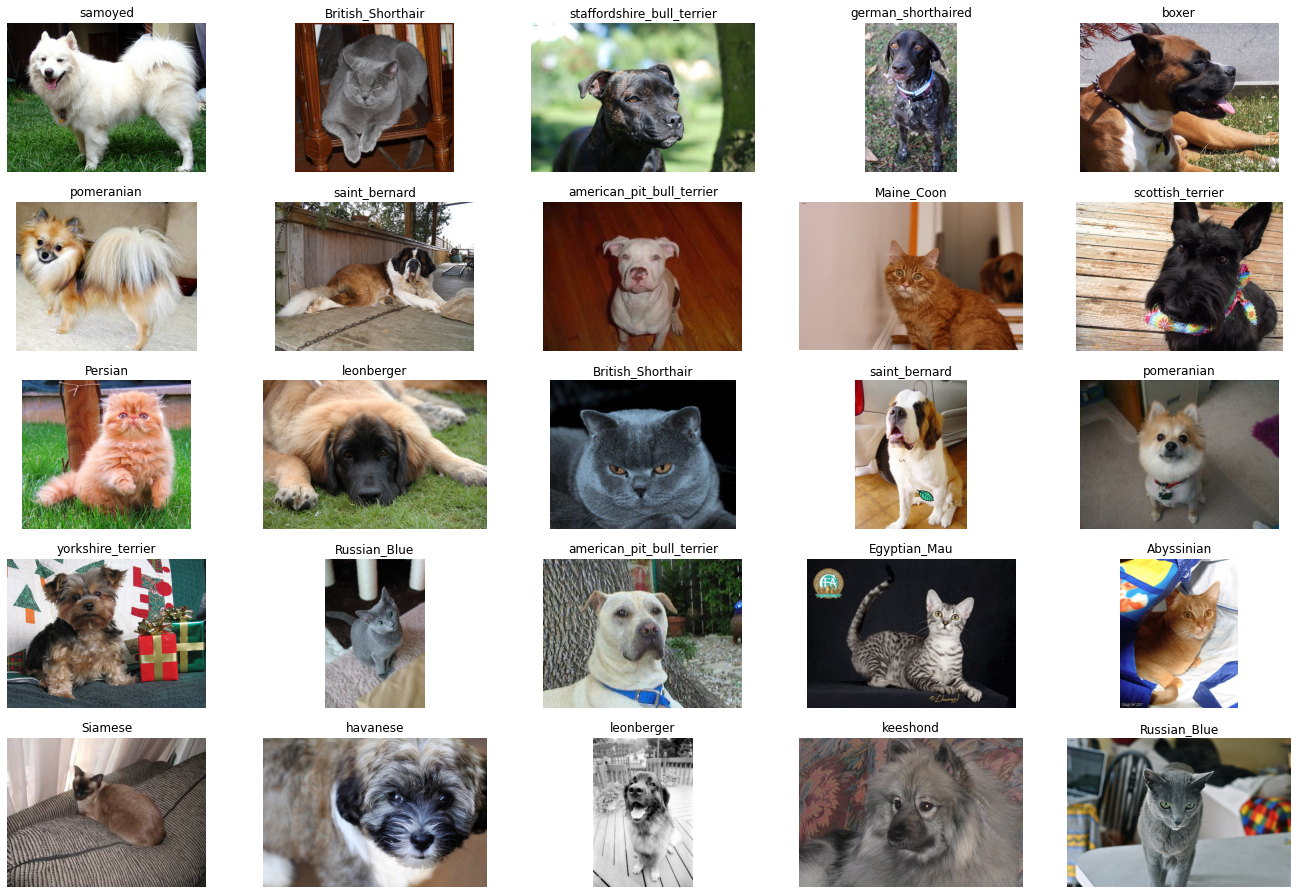

In [7]:
import matplotlib.pyplot as plt
from random import randint

def plot_random_images(images, labels):
    f, ax = plt.subplots(5, 5)
    f.subplots_adjust(0, 0, 3, 3)

    for i in range(0, 5, 1):
        for j in range(0, 5, 1):
            rnd_number = randint(0, len(images))
            ax[i, j].imshow(images[rnd_number])
            ax[i, j].set_title(labels[rnd_number])
            ax[i, j].axis('off')


plot_random_images(images_images, labels_images)

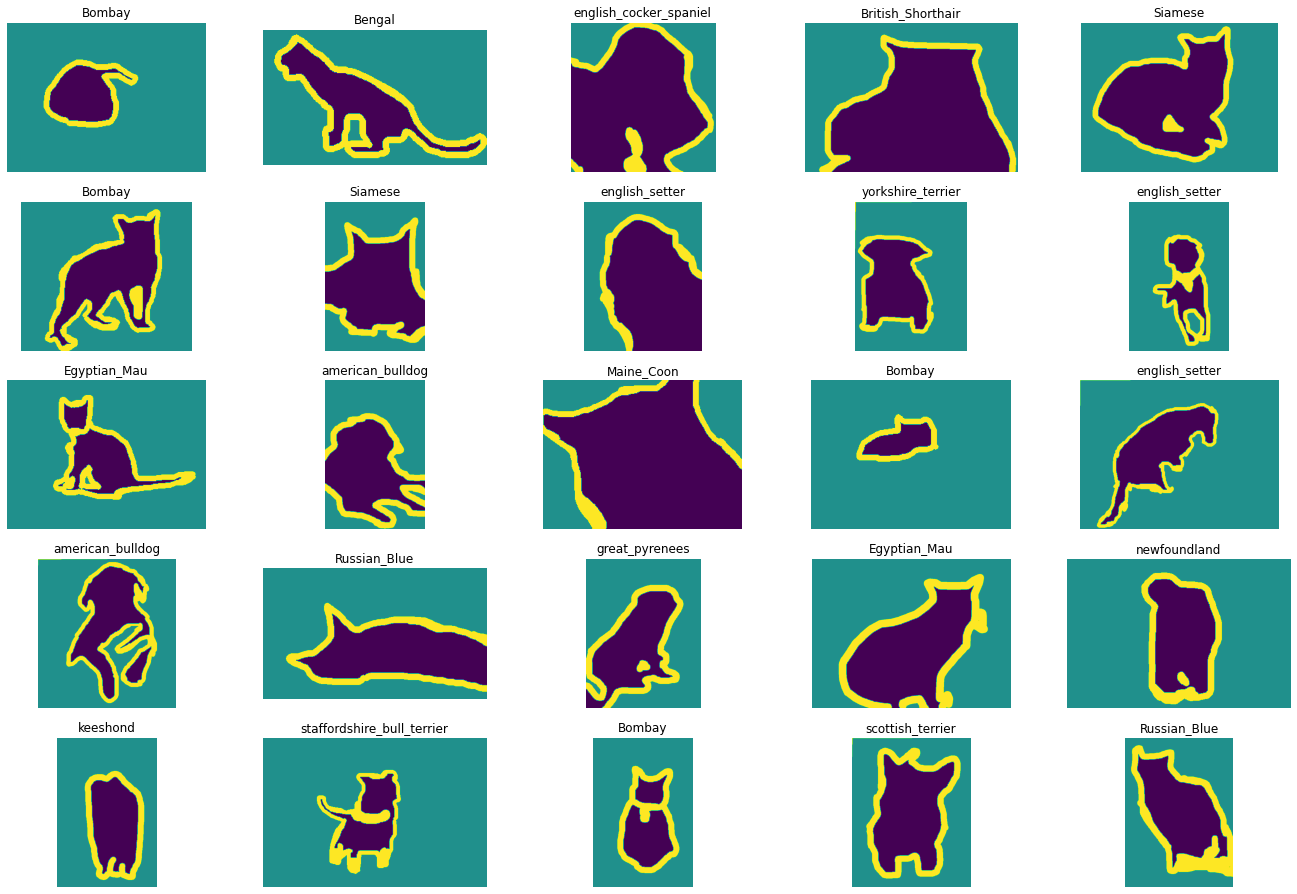

In [8]:
plot_random_images(images_annotations, labels_annotations)

Pegando imagens aleatórias de gatos e cachorros de diferentes raças, pode-se perceber:

- Variedade de planos de fundo (como paisagens e ambientes internos)
- Imagens contendo objetos a mais (cama, briquedo, sapato, árvore, cortina)
- Posições diferentes dos animais (correndo, deitado, de pé, sentando, com a língua para fora)
- Ângulos diferentes dos animais (de frente, de lado)
- Diferença de iluminação

Concluindo, há uma grande variedade de situações que podem dificultar uma boa classificação do modelo.

Neste caso, uma possível solução para a grande quantidade de variação nas imagens é utilizar os trimaps para a redução de dimensionalidade. Ao mesmo tempo, isso acarreta em uma enorme perda de informações. Contudo, essa análise não está incluída no escopo do projeto, então as imagens trimap não serão usadas - fica apenas como uma reflexão.


### Algumas Estatísticas

In [ ]:
print(f'Total de pets: {len(y)}')

Total de pets: 7390


In [ ]:
from collections import Counter

In [ ]:
Counter(y)

Counter({'Abyssinian': 200,
         'Bengal': 200,
         'Birman': 200,
         'Bombay': 200,
         'British_Shorthair': 200,
         'Egyptian_Mau': 200,
         'Maine_Coon': 200,
         'Persian': 200,
         'Ragdoll': 200,
         'Russian_Blue': 200,
         'Siamese': 200,
         'Sphynx': 200,
         'american_bulldog': 200,
         'american_pit_bull_terrier': 200,
         'basset_hound': 200,
         'beagle': 200,
         'boxer': 200,
         'chihuahua': 200,
         'english_cocker_spaniel': 200,
         'english_setter': 200,
         'german_shorthaired': 200,
         'great_pyrenees': 200,
         'havanese': 200,
         'japanese_chin': 200,
         'keeshond': 200,
         'leonberger': 200,
         'miniature_pinscher': 200,
         'newfoundland': 200,
         'pomeranian': 200,
         'pug': 200,
         'saint_bernard': 200,
         'samoyed': 200,
         'scottish_terrier': 199,
         'shiba_inu': 200,
         'staf

Fazendo a contagem de cada raça de cães e gatos, pode-se notar que é um dataset com categorias bem balanceadas.

Indo mais a fundo, vamos separar as raças de cães e gatos

In [ ]:
cat_breeds = [
    'Abyssinian',
    'Bengal',
    'Birman',
    'Bombay',
    'British_Shorthair',
    'Egyptian_Mau',
    'Maine_Coon',
    'Persian',
    'Ragdoll',
    'Russian_Blue',
    'Siamese',
    'Sphynx'  
]

In [ ]:
dog_breeds = [
    'american_bulldog',
    'american_pit_bull_terrier',
    'basset_hound',
    'beagle',
    'boxer',
    'chihuahua',
    'english_cocker_spaniel',
    'english_setter',
    'german_shorthaired',
    'great_pyrenees',
    'havanese',
    'japanese_chin',
    'keeshond',
    'leonberger',
    'miniature_pinscher',
    'newfoundland',
    'pomeranian',
    'pug',
    'saint_bernard',
    'samoyed',
    'scottish_terrier',
    'shiba_inu',
    'staffordshire_bull_terrier',
    'wheaten_terrier',
    'yorkshire_terrier'   
]

In [ ]:
df = pd.DataFrame({'breed': y})
df['dog'] = df['breed'].isin(dog_breeds)

In [ ]:
df['dog'].value_counts()

True     4990
False    2400
Name: dog, dtype: int64

É possível perceber que temos quase o dobro de caẽs em relação à gatos.

### 3 - Quais as dimensões e quantos canais de cores possuem a imagem?


Como visto no tópico 2, cada imagem tem uma dimensão diferente. Existem 1022 dimensoes diferentes no dataset. A seguir é possível ver as mais comuns

In [9]:
from collections import Counter
dim = []

for i in range(len(images_images)):
    dim.append(images_images[i].size)

counter = Counter(dim)
print(len(counter), 'dimensões diferentes.')
print('As dimensões mais comuns:')
for t in counter.most_common(5):
    print(f'{t[0]}: {t[1]}')

1022 dimensões diferentes.
As dimensões mais comuns:
(500, 375): 1425
(500, 333): 1072
(375, 500): 511
(333, 500): 509
(300, 225): 266


### 4 - Implementação de pelo menos uma arquitetura de rede CNN:

In [ ]:
EPOCHS = 150
CLASSES = 2

In [ ]:
rede_simples = Sequential()

rede_simples.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
rede_simples.add(MaxPooling2D())
rede_simples.add(Conv2D(64, (5,5), activation='relu'))
rede_simples.add(MaxPooling2D())
rede_simples.add(Conv2D(128, (5,5), activation='relu'))
rede_simples.add(MaxPooling2D())
rede_simples.add(Flatten())
rede_simples.add(Dense(2))
rede_simples.add(Activation('sigmoid'))
                 
rede_simples.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0

In [ ]:
rede_simples.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico = rede_simples.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=EPOCHS,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 34s 469ms/step - loss: 0.6273 - accuracy: 0.6882 - val_loss: 0.6557 - val_accuracy: 0.6023
Epoch 2/150
46/46 [==============================] - 32s 703ms/step - loss: 0.5978 - accuracy: 0.6970 - val_loss: 0.6933 - val_accuracy: 0.6023
Epoch 3/150
46/46 [==============================] - 19s 419ms/step - loss: 0.5881 - accuracy: 0.6980 - val_loss: 0.6877 - val_accuracy: 0.6065
Epoch 4/150
46/46 [==============================] - 19s 420ms/step - loss: 0.5733 - accuracy: 0.7031 - val_loss: 0.6325 - val_accuracy: 0.6037
Epoch 5/150
46/46 [==============================] - 19s 420ms/step - loss: 0.5582 - accuracy: 0.7089 - val_loss: 0.7007 - val_accuracy: 0.6080
Epoch 6/150
46/46 [==============================] - 19s 420ms/step - loss: 0.5304 - accuracy: 0.7337 - val_loss: 0.5545 - val_accuracy: 0.6932
Epoch 7/150
46/46 [==============================] - 19s 417ms/step - loss: 0.4881 - accuracy: 0.7582 - val_loss: 0.5991 - val_accuracy:

In [ ]:
rede_simples.save("simple_model.h5", overwrite=True)

##### Avaliação do modelo

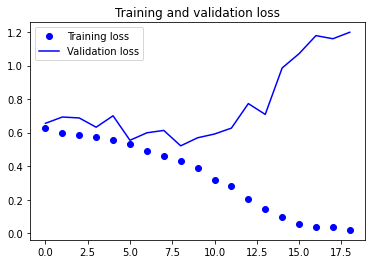

In [ ]:
loss = historico.history['loss']
val_loss = historico.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Como pode se observar no gráfico acima, houve um overfitting da rede. A acurácia de treino foi aumentando enquanto a acurárica da validação estagnou. Ficou 0.99 contra 0.75, valores bem distantes, mostrando que o modelo não estava conseguindo generalizar tão bem na base de validação.

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

In [ ]:
rede_simples.evaluate_generator(generator=val_dataset,
                                steps=STEP_SIZE_TEST)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1996: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.2213108539581299, 0.7508522868156433]

In [ ]:
test_dataset.reset()
pred = rede_simples.predict_generator(test_dataset,
                                      steps=STEP_SIZE_TEST,
                                      verbose=1)

  15/3669 [..............................] - ETA: 14s 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 25s 7ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

In [ ]:
labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
y_pred = np.argmax(pred, axis=1)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.64      0.58      0.61      1183
           2       0.81      0.84      0.83      2486

    accuracy                           0.76      3669
   macro avg       0.72      0.71      0.72      3669
weighted avg       0.75      0.76      0.76      3669



A rede teve uma acurácia na base de teste de 0.76. No geral, conseguiu se sair melhor na classificação de cães, como é possível ver no f1-score (0.83). Isso pode ser devido à ter o dobro de imagens de cães.

In [ ]:
filenames = test_dataset.filenames
results = pd.DataFrame({"Filename": filenames,
                      "Predictions": predictions})
results.to_csv("results.csv",index=False)

#### 4.1 Usando modelo com Augmentation

In [ ]:
BATCH_SIZE = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2, 
    rescale=1/255,
    rotation_range = 5,
    width_shift_range=[-10,10], 
    height_shift_range=[-10,10]
)

train_dataset = train_datagen.flow_from_dataframe(dataframe=train_data_frame,
                                        directory=IMAGE_BASE_PATH,
                                        x_col='filename',
                                        y_col='label',
                                        target_size=(128, 128),
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE,
                                        subset='training',
                                        shuffle=True,
                                        seed=42)

val_dataset = train_datagen.flow_from_dataframe(dataframe=train_data_frame,
                                      directory=IMAGE_BASE_PATH,
                                      x_col='filename',
                                      y_col='label',
                                      target_size=(128, 128),
                                      class_mode='categorical',
                                      batch_size=BATCH_SIZE,
                                      subset='validation',
                                      shuffle=True,
                                      seed=42)


In [ ]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=(128,128,3), activation='relu'))
model.add(MaxPooling2D())
model.add(SpatialDropout2D(0.5))

model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D())
model.add(SpatialDropout2D(0.5))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D())
model.add(SpatialDropout2D(0.5))

model.add(Flatten())

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', 
                     metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', min_delta = 0.001, patience = 10)

In [ ]:
historico = model.fit_generator(train_dataset,
  steps_per_epoch = train_dataset.samples // 64,
  validation_data = val_dataset, 
  validation_steps = val_dataset.samples // 64,
  epochs = 50,
  callbacks=[es])

In [ ]:
loss = historico.history['loss']
val_loss = historico.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 5 - Utilize a base de dados em tons de cinza e realize o treinamento novamente da arquitetura proposta no ponto anterior. Existe alguma diferença de desempenho da rede?

#### Train and validation datasets

In [ ]:
BATCH_SIZE = 64

train_datagen_grayscale = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_dataset_grayscale = train_datagen_grayscale.flow_from_dataframe(dataframe=train_data_frame,
                                        directory=IMAGE_BASE_PATH,
                                        x_col='filename',
                                        y_col='label',
                                        color_mode='grayscale',
                                        target_size=(128, 128),
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE,
                                        subset='training',
                                        shuffle=True,
                                        seed=42)

val_dataset_grayscale = train_datagen_grayscale.flow_from_dataframe(dataframe=train_data_frame,
                                      directory=IMAGE_BASE_PATH,
                                      x_col='filename',
                                      y_col='label',
                                      color_mode='grayscale',
                                      target_size=(128, 128),
                                      class_mode='categorical',
                                      batch_size=BATCH_SIZE,
                                      subset='validation',
                                      shuffle=True,
                                      seed=42)

Found 2944 validated image filenames belonging to 2 classes.
Found 736 validated image filenames belonging to 2 classes.


#### Test dataset

In [ ]:
test_datagen_grayscale = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_dataset_grayscale = test_datagen_grayscale.flow_from_dataframe(dataframe=test_data_frame,
                                        directory=IMAGE_BASE_PATH,
                                        x_col='filename',
                                        y_col='label',
                                        color_mode='grayscale',
                                        target_size=(128, 128),
                                        class_mode='categorical',
                                        batch_size=1,
                                        shuffle=False,
                                        seed=42)

Found 3669 validated image filenames belonging to 2 classes.


#### Treino

In [ ]:
rede_simples = Sequential()

rede_simples.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,1)))
rede_simples.add(MaxPooling2D())
rede_simples.add(Conv2D(64, (5,5), activation='relu'))
rede_simples.add(MaxPooling2D())
rede_simples.add(Conv2D(128, (5,5), activation='relu'))
rede_simples.add(MaxPooling2D())
rede_simples.add(Flatten())
rede_simples.add(Dense(2))
rede_simples.add(Activation('sigmoid'))
                 
rede_simples.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)            

In [ ]:
rede_simples.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico_grayscale = rede_simples.fit_generator(train_dataset_grayscale, 
                            steps_per_epoch=train_dataset_grayscale.n // BATCH_SIZE,
                            validation_data=val_dataset_grayscale,
                            validation_steps=val_dataset_grayscale.n // BATCH_SIZE,
                            epochs=EPOCHS,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 22s 441ms/step - loss: 0.6509 - accuracy: 0.6895 - val_loss: 0.6660 - val_accuracy: 0.6023
Epoch 2/150
46/46 [==============================] - 30s 672ms/step - loss: 0.6086 - accuracy: 0.6990 - val_loss: 0.6726 - val_accuracy: 0.6023
Epoch 3/150
46/46 [==============================] - 30s 673ms/step - loss: 0.5988 - accuracy: 0.6960 - val_loss: 0.6556 - val_accuracy: 0.6179
Epoch 4/150
46/46 [==============================] - 24s 530ms/step - loss: 0.5840 - accuracy: 0.7021 - val_loss: 0.6249 - val_accuracy: 0.6151
Epoch 5/150
46/46 [==============================] - 29s 635ms/step - loss: 0.5598 - accuracy: 0.7086 - val_loss: 0.5936 - val_accuracy: 0.6690
Epoch 6/150
46/46 [==============================] - 26s 581ms/step - loss: 0.5299 - accuracy: 0.7337 - val_loss: 0.6121 - val_accuracy: 0.6321
Epoch 7/150
46/46 [==============================] - 23s 515ms/step - loss: 0.5165 - accuracy: 0.7347 - val_loss: 0.5787 - val_accuracy:

##### Avaliação do modelo

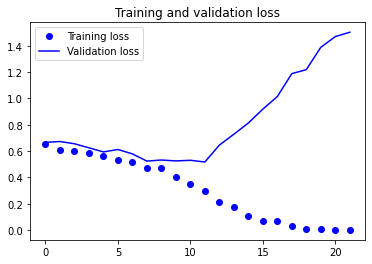

In [ ]:
loss = historico_grayscale.history['loss']
val_loss = historico_grayscale.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

O gráfico acima mostra que o modelo continua com o overfitting bem alto

In [ ]:
STEP_SIZE_TEST = test_dataset_grayscale.n//test_dataset_grayscale.batch_size

test_dataset_grayscale.reset()
pred = rede_simples.predict_generator(test_dataset_grayscale,
                                      steps=STEP_SIZE_TEST,
                                      verbose=1)

  14/3669 [..............................] - ETA: 14s 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 37s 10ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset_grayscale.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.65      0.55      0.60      1183
           2       0.80      0.86      0.83      2486

    accuracy                           0.76      3669
   macro avg       0.73      0.71      0.71      3669
weighted avg       0.75      0.76      0.76      3669



Utilizando a base de dados em tons de cinza, obteve-se uma acurácia na base de testes de 0.76, um valor idêntico ao modelo anterior com base de dados em RGB. 

### 6 - Escolha uma arquitetura de rede proposta na literatura

Rede Pŕe-treinada (ResNet)

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
flatten = Flatten()
dense = Dense(2,activation='sigmoid')

model = Sequential([
        base_model,
        flatten,
        dense
    ])

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

history = model.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=150,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 28s 450ms/step - loss: 1.5899 - accuracy: 0.7296 - val_loss: 125573.5547 - val_accuracy: 0.6023
Epoch 2/150
46/46 [==============================] - 18s 388ms/step - loss: 1.2772 - accuracy: 0.7317 - val_loss: 152598.4844 - val_accuracy: 0.6023
Epoch 3/150
46/46 [==============================] - 18s 387ms/step - loss: 1.5378 - accuracy: 0.7228 - val_loss: 0.9552 - val_accuracy: 0.3991
Epoch 4/150
46/46 [==============================] - 18s 389ms/step - loss: 1.2767 - accuracy: 0.7157 - val_loss: 173.8801 - val_accuracy: 0.5980
Epoch 5/150
46/46 [==============================] - 19s 406ms/step - loss: 0.9181 - accuracy: 0.7058 - val_loss: 0.7968 - val_accuracy: 0.4034
Epoch 6/150
46/46 [==============================] - 18s 394ms/step - loss: 0.7425 - accuracy: 0.7221 - val_loss: 1.1717 - val_accuracy: 0.4034
Epoch 7/150
46/46 [==============================] - 18s 395ms/step - loss: 0.7590 - accuracy: 0.7548 - val_loss: 1.0794 - v

#### Avaliação do modelo

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred = model.predict_generator(test_dataset,
                              steps=STEP_SIZE_TEST,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 35s 9ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.64      0.70      0.67      1183
           2       0.85      0.81      0.83      2486

    accuracy                           0.78      3669
   macro avg       0.75      0.76      0.75      3669
weighted avg       0.78      0.78      0.78      3669



* Utilizando a rede escolhida de forma pré-treinada, qual o desempenho desta arquitetura para este problema?

O desempenho da rede pré-treinada foi um pouco melhor do que as redes anteriores, ficando com uma acurácia de 0.78.

* A rede apresenta overfiting ou underfiting?

A rede apresenta um overfitting, tendo uma acurácia de treino de 0.99, e de validação de 0.77.


#### Colocando mais camadas 

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

seq = Sequential()
seq.add(Flatten())
seq.add(Dense(32, activation='relu'))
seq.add(Dropout(0.5))
seq.add(Dense(64, activation='relu'))
seq.add(Dropout(0.5))
seq.add(Dense(128, activation='relu'))
seq.add(Dense(2))
seq.add(Activation('sigmoid'))

model = Sequential([
        base_model,
        seq
    ])

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico = model.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=150,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 26s 407ms/step - loss: 0.6990 - accuracy: 0.6702 - val_loss: 74.8509 - val_accuracy: 0.5994
Epoch 2/150
46/46 [==============================] - 19s 406ms/step - loss: 0.5852 - accuracy: 0.6953 - val_loss: 0.6752 - val_accuracy: 0.6037
Epoch 3/150
46/46 [==============================] - 18s 391ms/step - loss: 0.4933 - accuracy: 0.6974 - val_loss: 0.6946 - val_accuracy: 0.4062
Epoch 4/150
46/46 [==============================] - 18s 387ms/step - loss: 0.6351 - accuracy: 0.7082 - val_loss: 53.5317 - val_accuracy: 0.6009
Epoch 5/150
46/46 [==============================] - 18s 388ms/step - loss: 0.6483 - accuracy: 0.6865 - val_loss: 0.6745 - val_accuracy: 0.5980
Epoch 6/150
46/46 [==============================] - 18s 389ms/step - loss: 0.6157 - accuracy: 0.6923 - val_loss: 0.6765 - val_accuracy: 0.5980
Epoch 7/150
46/46 [==============================] - 19s 425ms/step - loss: 0.5969 - accuracy: 0.6967 - val_loss: 0.6764 - val_accurac

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred = model.predict_generator(test_dataset,
                              steps=STEP_SIZE_TEST,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 35s 9ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.70      0.64      0.67      1183
           2       0.84      0.87      0.85      2486

    accuracy                           0.79      3669
   macro avg       0.77      0.75      0.76      3669
weighted avg       0.79      0.79      0.79      3669



* Adicione camadas na rede, foi observada mudança de desempenho do modelo?

Ainda é possível notar um overfitting, mas a acurácia do modelo ficou um pouco melhor que o modelo anterior, (079 e 0.78)

#### Descongelando parcialmente

In [ ]:
base_mod = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

base_mod.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
base_mod.layers[100].trainable = False

base_mod.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
seq = Sequential()
seq.add(Flatten())
seq.add(Dense(32, activation='relu'))
seq.add(Dropout(0.5))
seq.add(Dense(64, activation='relu'))
seq.add(Dropout(0.5))
seq.add(Dense(128, activation='relu'))
seq.add(Dense(2))
seq.add(Activation('sigmoid'))

mod = Sequential([
        base_mod,
        seq
    ])

In [ ]:
mod.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico = mod.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=150,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 29s 512ms/step - loss: 0.8499 - accuracy: 0.6681 - val_loss: 0.6766 - val_accuracy: 0.5952
Epoch 2/150
46/46 [==============================] - 25s 548ms/step - loss: 0.6027 - accuracy: 0.6872 - val_loss: 0.6749 - val_accuracy: 0.5952
Epoch 3/150
46/46 [==============================] - 19s 409ms/step - loss: 0.5525 - accuracy: 0.7001 - val_loss: 0.6727 - val_accuracy: 0.6037
Epoch 4/150
46/46 [==============================] - 18s 391ms/step - loss: 0.4607 - accuracy: 0.7371 - val_loss: 0.6879 - val_accuracy: 0.6065
Epoch 5/150
46/46 [==============================] - 20s 448ms/step - loss: 0.4066 - accuracy: 0.8074 - val_loss: 0.7112 - val_accuracy: 0.4091
Epoch 6/150
46/46 [==============================] - 24s 533ms/step - loss: 0.3724 - accuracy: 0.8288 - val_loss: 0.8266 - val_accuracy: 0.4020
Epoch 7/150
46/46 [==============================] - 23s 507ms/step - loss: 0.3138 - accuracy: 0.8434 - val_loss: 1.8202 - val_accuracy:

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred = mod.predict_generator(test_dataset,
                              steps=STEP_SIZE_TEST,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 36s 10ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.33      0.94      0.49      1183
           2       0.77      0.09      0.17      2486

    accuracy                           0.37      3669
   macro avg       0.55      0.52      0.33      3669
weighted avg       0.63      0.37      0.27      3669



* Descongele parcialmente a rede escolhida, foi observada mudança de desempenho do modelo?

O desempenho do modelo piorou significamente.

#### Descongelando totalmente

In [ ]:
base_mod = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

base_mod.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
base_mod.trainable = False

base_mod.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
seq = Sequential()
seq.add(Flatten())
seq.add(Dense(32, activation='relu'))
seq.add(Dropout(0.5))
seq.add(Dense(64, activation='relu'))
seq.add(Dropout(0.5))
seq.add(Dense(128, activation='relu'))
seq.add(Dense(2))
seq.add(Activation('sigmoid'))

mod = Sequential([
        base_mod,
        seq
    ])

In [ ]:
mod.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico = mod.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=150,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 20s 369ms/step - loss: 0.6409 - accuracy: 0.6885 - val_loss: 0.6742 - val_accuracy: 0.6023
Epoch 2/150
46/46 [==============================] - 16s 350ms/step - loss: 0.6224 - accuracy: 0.6974 - val_loss: 0.6795 - val_accuracy: 0.6009
Epoch 3/150
46/46 [==============================] - 16s 350ms/step - loss: 0.6117 - accuracy: 0.6987 - val_loss: 0.7027 - val_accuracy: 0.5966
Epoch 4/150
46/46 [==============================] - 16s 349ms/step - loss: 0.6150 - accuracy: 0.6936 - val_loss: 0.6946 - val_accuracy: 0.5994
Epoch 5/150
46/46 [==============================] - 16s 344ms/step - loss: 0.6133 - accuracy: 0.6953 - val_loss: 0.6886 - val_accuracy: 0.6023
Epoch 6/150
46/46 [==============================] - 16s 347ms/step - loss: 0.6117 - accuracy: 0.6974 - val_loss: 0.6925 - val_accuracy: 0.5923
Epoch 7/150
46/46 [==============================] - 16s 349ms/step - loss: 0.6085 - accuracy: 0.7031 - val_loss: 0.7047 - val_accuracy:

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred = mod.predict_generator(test_dataset,
                              steps=STEP_SIZE_TEST,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 36s 9ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1183
           2       0.68      1.00      0.81      2486

    accuracy                           0.68      3669
   macro avg       0.34      0.50      0.40      3669
weighted avg       0.46      0.68      0.55      3669



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* Descongele totalmente a rede escolhida, foi observada mudança de desempenho do modelo?

O desempenho do modelo piorou um pouco.

### Solução 2 - Classificar raças de animais

1 - Implementação de pelo menos uma arquitetura de rede CNN: 

  * Qual o desempenho da rede? (métrica de classificação a critério do aluno)
  * A rede apresenta overfiting ou underfiting? 

2 - Escolha uma arquitetura de rede proposta na literatura (disponíveis em https://keras.io/api/applications/)

* Utilizando a rede escolhida de forma pré-treinada, qual o desempenho desta arquitetura para este problema?
* A rede apresenta overfiting ou underfiting?
* Descongele parcialmente a rede escolhida, foi observada mudança de desempenho do modelo?
* Adicione camadas na rede, foi observada mudança de desempenho do modelo?
* Descongele totalmente a rede escolhida, foi observada mudança de desempenho do modelo?

3 - Escolha pelo menos uma arquitetura de rede dos tópicos 1 ou 2 e utilize técnicas de oversampling (https://keras.io/api/preprocessing/image/ ou https://albumentations.ai) nesta rede. Como você avalia o desempenho do modelo realizando o oversampling?

4 - Escolha o melhor modelo de rede desenvolvido nos tópicos anteriores e analise os resultados:
  * Qual o desempenho do modelo para cada raça?
  * Quais raças possuem menor desempenho? 
  * Existe algum pre-processamento que você acredite que possa melhorar o desempenho do modelo para estas raças de menor desempenho?

### Leitura da Base de Dados

#### Treino e Validação

In [ ]:
IMAGE_BASE_PATH = 'images'
SAMPLE_FILES = 'annotations/list.txt'
TRAIN_FILES = 'annotations/trainval.txt'
TEST_FILES = 'annotations/test.txt'

files = open(TRAIN_FILES)
train_files = []
train_labels = []
for txt_line in files:
    if txt_line[0] == '#':
        continue
    file_name, class_id, cat_dog_id, sub_class_id = txt_line.split(' ')
    train_files.append(file_name + '.jpg')
    train_labels.append(class_id)
files.close()

train_data_frame = pd.DataFrame({'filename': train_files, 'label': train_labels})

In [ ]:
BATCH_SIZE = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_dataset = train_datagen.flow_from_dataframe(dataframe=train_data_frame,
                                        directory=IMAGE_BASE_PATH,
                                        x_col='filename',
                                        y_col='label',
                                        target_size=(128, 128),
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE,
                                        subset='training',
                                        shuffle=True,
                                        seed=42)

val_dataset = train_datagen.flow_from_dataframe(dataframe=train_data_frame,
                                      directory=IMAGE_BASE_PATH,
                                      x_col='filename',
                                      y_col='label',
                                      target_size=(128, 128),
                                      class_mode='categorical',
                                      batch_size=BATCH_SIZE,
                                      subset='validation',
                                      shuffle=True,
                                      seed=42)

Found 2944 validated image filenames belonging to 37 classes.
Found 736 validated image filenames belonging to 37 classes.


#### Teste

In [ ]:
files = open(TEST_FILES)
test_files = []
test_labels = []
for txt_line in files:
    if txt_line[0] == '#':
        continue
    file_name, class_id, cat_dog_id, sub_class_id = txt_line.split(' ')
    test_files.append(file_name + '.jpg')
    test_labels.append(class_id)
files.close()

test_data_frame = pd.DataFrame({'filename': test_files, 'label': test_labels})

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_dataset = test_datagen.flow_from_dataframe(dataframe=test_data_frame,
                                        directory=IMAGE_BASE_PATH,
                                        x_col='filename',
                                        y_col='label',
                                        target_size=(128, 128),
                                        class_mode='categorical',
                                        batch_size=1,
                                        shuffle=False,
                                        seed=42)

Found 3669 validated image filenames belonging to 37 classes.


### 1 - Implementação de pelo menos uma arquitetura de rede CNN: 

In [ ]:
EPOCHS = 150
CLASSES = 37

In [ ]:
rede_simples = Sequential()

rede_simples.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
rede_simples.add(MaxPooling2D())
rede_simples.add(Conv2D(64, (5,5), activation='relu'))
rede_simples.add(MaxPooling2D())
rede_simples.add(Conv2D(128, (5,5), activation='relu'))
rede_simples.add(MaxPooling2D())
rede_simples.add(Flatten())
rede_simples.add(Dense(37))
rede_simples.add(Activation('softmax'))
                 
rede_simples.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 124, 124, 32)      2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)            

In [ ]:
rede_simples.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])


In [ ]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico = rede_simples.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=EPOCHS,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 17s 370ms/step - loss: 3.5498 - accuracy: 0.0431 - val_loss: 4.0930 - val_accuracy: 0.0000e+00
Epoch 2/150
46/46 [==============================] - 16s 365ms/step - loss: 3.2166 - accuracy: 0.1264 - val_loss: 4.2571 - val_accuracy: 0.0028
Epoch 3/150
46/46 [==============================] - 17s 366ms/step - loss: 2.9070 - accuracy: 0.1957 - val_loss: 3.6829 - val_accuracy: 0.0355
Epoch 4/150
46/46 [==============================] - 17s 367ms/step - loss: 2.5465 - accuracy: 0.3040 - val_loss: 4.1905 - val_accuracy: 0.0526
Epoch 5/150
46/46 [==============================] - 16s 364ms/step - loss: 2.0769 - accuracy: 0.4185 - val_loss: 4.6403 - val_accuracy: 0.0668
Epoch 6/150
46/46 [==============================] - 17s 365ms/step - loss: 1.4916 - accuracy: 0.5774 - val_loss: 5.6883 - val_accuracy: 0.0526
Epoch 7/150
46/46 [==============================] - 19s 425ms/step - loss: 0.9421 - accuracy: 0.7266 - val_loss: 6.5540 - val_accur

#### Avaliação do modelo

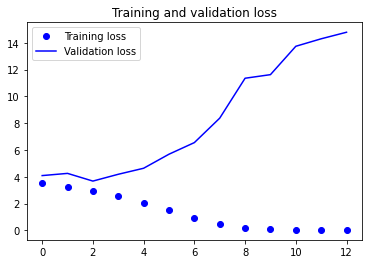

In [ ]:
loss = historico.history['loss']
val_loss = historico.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred = rede_simples.predict_generator(test_dataset,
                                      steps=STEP_SIZE_TEST,
                                      verbose=1)

  27/3669 [..............................] - ETA: 14s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 27s 7ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.12      0.06      0.08        98
          10       0.17      0.08      0.11       100
          11       0.00      0.00      0.00       100
          12       0.26      0.06      0.10        97
          13       0.11      0.07      0.09       100
          14       0.07      0.03      0.04       100
          15       0.19      0.10      0.13       100
          16       0.14      0.29      0.19       100
          17       0.10      0.12      0.11       100
          18       0.14      0.32      0.19       100
          19       0.11      0.23      0.15        99
           2       0.07      0.04      0.05       100
          20       0.20      0.16      0.18       100
          21       0.10      0.10      0.10       100
          22       0.12      0.17      0.14       100
          23       0.28      0.29      0.29       100
          24       0.20      0.31      0.25       100
          25       0.17    

* Qual o desempenho da rede? (métrica de classificação a critério do aluno)

A acurácia ficou bem baixa (0.14) em relação aos modelos que classificam apenas cão e gato, principalmente porque agora ele precisa classificar 37 classes.

* A rede apresenta overfiting ou underfiting?

A rede apresenta overfitting, pois a acurácia do treino com a acurácia da validação ficaram muito distantes

#### 2 - Escolha uma arquitetura de rede proposta na literatura

In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

flatten = Flatten()
dense = Dense(37,activation='softmax')

model = Sequential([
        base_model,
        flatten,
        dense
    ])

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico = model.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=150,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 34s 505ms/step - loss: 3.5318 - accuracy: 0.0982 - val_loss: 994.2584 - val_accuracy: 0.0000e+00
Epoch 2/150
46/46 [==============================] - 19s 407ms/step - loss: 2.6207 - accuracy: 0.3291 - val_loss: 2705.4045 - val_accuracy: 0.0000e+00
Epoch 3/150
46/46 [==============================] - 18s 405ms/step - loss: 2.0496 - accuracy: 0.4813 - val_loss: 3032.7822 - val_accuracy: 0.0000e+00
Epoch 4/150
46/46 [==============================] - 19s 408ms/step - loss: 1.4234 - accuracy: 0.6022 - val_loss: 11.6417 - val_accuracy: 0.0909
Epoch 5/150
46/46 [==============================] - 18s 405ms/step - loss: 0.9618 - accuracy: 0.7082 - val_loss: 6.5150 - val_accuracy: 0.0639
Epoch 6/150
46/46 [==============================] - 19s 407ms/step - loss: 0.6791 - accuracy: 0.7911 - val_loss: 3.1576 - val_accuracy: 0.2358
Epoch 7/150
46/46 [==============================] - 19s 411ms/step - loss: 0.3841 - accuracy: 0.8849 - val_loss: 3

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred = model.predict_generator(test_dataset,
                              steps=STEP_SIZE_TEST,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 56s 15ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.31      0.76      0.44        98
          10       0.73      0.11      0.19       100
          11       0.37      0.25      0.30       100
          12       0.51      0.52      0.51        97
          13       0.39      0.37      0.38       100
          14       0.43      0.24      0.31       100
          15       0.35      0.27      0.31       100
          16       0.56      0.54      0.55       100
          17       0.48      0.24      0.32       100
          18       0.36      0.74      0.48       100
          19       0.84      0.37      0.52        99
           2       0.75      0.03      0.06       100
          20       0.68      0.32      0.44       100
          21       0.29      0.61      0.39       100
          22       0.25      0.51      0.34       100
          23       0.71      0.47      0.57       100
          24       0.42      0.45      0.43       100
          25       0.26    

* Utilizando a rede escolhida de forma pré-treinada, qual o desempenho desta arquitetura para este problema?

O desempenho foi bom em relação ao modelo feito na mão. 0.4 de acurácia na base de teste contra 0.14 da rede feita na mão

* A rede apresenta overfiting ou underfiting?

Apresenta overfitting bem acentuado

#### Colocando mais camadas

In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

seq = Sequential()
seq.add(Flatten())
seq.add(Dense(128, activation='relu'))
seq.add(Dropout(0.5))
seq.add(Dense(252, activation='relu'))
seq.add(Dropout(0.5))
seq.add(Dense(600, activation='relu'))
seq.add(Dense(37))
seq.add(Activation('softmax'))

model = Sequential([
        base_model,
        seq
    ])

In [ ]:
opt = adam_v2.Adam(0.01)

model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico = model.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=150,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 38s 548ms/step - loss: 3.7126 - accuracy: 0.0285 - val_loss: 657459968.0000 - val_accuracy: 0.0000e+00
Epoch 2/150
46/46 [==============================] - 23s 501ms/step - loss: 3.5740 - accuracy: 0.0299 - val_loss: 61640.5273 - val_accuracy: 0.0639
Epoch 3/150
46/46 [==============================] - 23s 503ms/step - loss: 3.5720 - accuracy: 0.0326 - val_loss: 4.0079 - val_accuracy: 0.0000e+00
Epoch 4/150
46/46 [==============================] - 23s 505ms/step - loss: 3.7017 - accuracy: 0.0265 - val_loss: 2380682.0000 - val_accuracy: 0.0000e+00
Epoch 5/150
46/46 [==============================] - 23s 504ms/step - loss: 3.5770 - accuracy: 0.0309 - val_loss: 29529.7832 - val_accuracy: 0.0000e+00
Epoch 6/150
46/46 [==============================] - 23s 502ms/step - loss: 3.6358 - accuracy: 0.0289 - val_loss: 4.0255 - val_accuracy: 0.0000e+00
Epoch 7/150
46/46 [==============================] - 23s 514ms/step - loss: 3.7143 - accuracy:

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred = model.predict_generator(test_dataset,
                              steps=STEP_SIZE_TEST,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 83s 22ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        98
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       100
          12       0.00      0.00      0.00        97
          13       0.00      0.00      0.00       100
          14       0.00      0.00      0.00       100
          15       0.00      0.00      0.00       100
          16       0.00      0.00      0.00       100
          17       0.00      0.00      0.00       100
          18       0.00      0.00      0.00       100
          19       0.00      0.00      0.00        99
           2       0.00      0.00      0.00       100
          20       0.00      0.00      0.00       100
          21       0.00      0.00      0.00       100
          22       0.00      0.00      0.00       100
          23       0.00      0.00      0.00       100
          24       0.03      1.00      0.05       100
          25       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



* Adicione camadas na rede, foi observada mudança de desempenho do modelo?

O modelo piorou significativamente, com 0.03 de acurácia. Isso pode ser devido ao overfitting, pois antes de adicionar camadas a mais, já estava com um overfitting alto. Aumentando a complexidade da rede, o overfitting tem tendência a aumentar mais ainda, com isso piora a capacidade de generalização.

#### Descongelando parcialmente

In [ ]:
base_mod = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

base_mod.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 63, 63, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 63, 63, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [ ]:
base_mod.layers[200].trainable = False

base_mod.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 63, 63, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 63, 63, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [ ]:
flatten = Flatten()
dense = Dense(37,activation='softmax')

model = Sequential([
        base_mod,
        flatten,
        dense
    ])

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico = model.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=150,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 46s 824ms/step - loss: 3.0101 - accuracy: 0.2602 - val_loss: 6.5662 - val_accuracy: 0.0804
Epoch 2/150
46/46 [==============================] - 30s 664ms/step - loss: 1.6116 - accuracy: 0.5550 - val_loss: 42.1904 - val_accuracy: 0.0759
Epoch 3/150
46/46 [==============================] - 23s 504ms/step - loss: 0.9463 - accuracy: 0.7269 - val_loss: 4.0976 - val_accuracy: 0.0833
Epoch 4/150
46/46 [==============================] - 23s 500ms/step - loss: 0.6400 - accuracy: 0.8026 - val_loss: 9.0904 - val_accuracy: 0.1057
Epoch 5/150
46/46 [==============================] - 23s 497ms/step - loss: 0.4804 - accuracy: 0.8638 - val_loss: 5.1441 - val_accuracy: 0.1949
Epoch 6/150
46/46 [==============================] - 23s 494ms/step - loss: 0.4732 - accuracy: 0.8621 - val_loss: 3.7040 - val_accuracy: 0.2158
Epoch 7/150
46/46 [==============================] - 23s 494ms/step - loss: 0.3379 - accuracy: 0.8974 - val_loss: 3.7222 - val_accuracy

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred = model.predict_generator(test_dataset,
                              steps=STEP_SIZE_TEST,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 78s 21ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.52      0.23      0.32        98
          10       0.61      0.38      0.47       100
          11       0.24      0.04      0.07       100
          12       0.70      0.48      0.57        97
          13       0.00      0.00      0.00       100
          14       0.06      0.94      0.11       100
          15       0.40      0.02      0.04       100
          16       0.00      0.00      0.00       100
          17       0.24      0.10      0.14       100
          18       0.26      0.65      0.38       100
          19       0.86      0.18      0.30        99
           2       0.04      0.07      0.05       100
          20       0.62      0.21      0.31       100
          21       0.56      0.24      0.34       100
          22       0.56      0.32      0.41       100
          23       0.26      0.79      0.39       100
          24       0.76      0.22      0.34       100
          25       0.79    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



* Descongele parcialmente a rede escolhida, foi observada mudança de desempenho do modelo?


O modelo ficou pior com o descongelamento parcial. (0.4 sem descongelamento vs 0.23 com descongelamento parcial)

#### Descongelando totalmente

In [ ]:
base_mod = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

base_mod.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 63, 63, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 63, 63, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [ ]:
base_mod.trainable = False

base_mod.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 63, 63, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 63, 63, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [ ]:
flatten = Flatten()
dense = Dense(37,activation='softmax')

model = Sequential([
        base_mod,
        flatten,
        dense
    ])

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico = model.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=150,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 26s 443ms/step - loss: 4.7100 - accuracy: 0.4983 - val_loss: 5.4420 - val_accuracy: 0.4211
Epoch 2/150
46/46 [==============================] - 19s 409ms/step - loss: 1.4349 - accuracy: 0.7578 - val_loss: 5.5732 - val_accuracy: 0.3735
Epoch 3/150
46/46 [==============================] - 19s 417ms/step - loss: 0.6504 - accuracy: 0.8553 - val_loss: 3.9783 - val_accuracy: 0.5193
Epoch 4/150
46/46 [==============================] - 18s 401ms/step - loss: 0.4261 - accuracy: 0.9049 - val_loss: 5.4187 - val_accuracy: 0.4375
Epoch 5/150
46/46 [==============================] - 18s 404ms/step - loss: 0.2016 - accuracy: 0.9436 - val_loss: 4.2717 - val_accuracy: 0.5193
Epoch 6/150
46/46 [==============================] - 18s 406ms/step - loss: 0.1005 - accuracy: 0.9721 - val_loss: 4.4352 - val_accuracy: 0.4777
Epoch 7/150
46/46 [==============================] - 18s 400ms/step - loss: 0.0523 - accuracy: 0.9847 - val_loss: 4.5121 - val_accuracy:

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred = model.predict_generator(test_dataset,
                              steps=STEP_SIZE_TEST,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 78s 21ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.52      0.49      0.51        98
          10       0.71      0.47      0.57       100
          11       0.75      0.42      0.54       100
          12       0.73      0.68      0.70        97
          13       0.64      0.57      0.60       100
          14       0.67      0.60      0.63       100
          15       0.73      0.76      0.75       100
          16       0.77      0.76      0.76       100
          17       0.54      0.75      0.63       100
          18       0.84      0.79      0.81       100
          19       0.83      0.77      0.80        99
           2       0.57      0.46      0.51       100
          20       0.74      0.85      0.79       100
          21       0.35      0.61      0.44       100
          22       0.67      0.72      0.70       100
          23       0.87      0.72      0.79       100
          24       0.67      0.56      0.61       100
          25       0.67    


* Descongele totalmente a rede escolhida, foi observada mudança de desempenho do modelo?

Com o descongelamento total, o desempenho aumentou, com uma acurácia de 0.64 na base de teste. (0.4 de acurácia no modelo sem o descongelamento total)

### 3 - Escolha pelo menos uma arquitetura de rede dos tópicos 1 ou 2 e utilize técnicas de oversampling (https://keras.io/api/preprocessing/image/ ou https://albumentations.ai) nesta rede.

In [ ]:
BATCH_SIZE = 64


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=90,
    horizontal_flip=True
)

train_dataset = train_datagen.flow_from_dataframe(dataframe=train_data_frame,
                                        directory=IMAGE_BASE_PATH,
                                        x_col='filename',
                                        y_col='label',
                                        target_size=(128, 128),
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        subset = 'training',
                                        seed=42)

val_dataset = train_datagen.flow_from_dataframe(dataframe=train_data_frame,
                                      directory=IMAGE_BASE_PATH,
                                      x_col='filename',
                                      y_col='label',
                                      target_size=(128, 128),
                                      class_mode='categorical',
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      subset = 'validation',
                                      seed=42)

Found 2944 validated image filenames belonging to 37 classes.
Found 736 validated image filenames belonging to 37 classes.


Foi escolhida a arquitetura com a rede pré-treinada

In [ ]:
base_mod = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

base_mod.trainable = False

In [ ]:
flatten = Flatten()
dense = Dense(37,activation='softmax')

model = Sequential([
        base_mod,
        flatten,
        dense
    ])

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico = model.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=150,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 38s 703ms/step - loss: 5.3404 - accuracy: 0.3200 - val_loss: 3.6112 - val_accuracy: 0.4375
Epoch 2/150
46/46 [==============================] - 38s 848ms/step - loss: 3.0754 - accuracy: 0.4840 - val_loss: 6.2236 - val_accuracy: 0.3452
Epoch 3/150
46/46 [==============================] - 34s 763ms/step - loss: 3.0493 - accuracy: 0.5065 - val_loss: 5.4893 - val_accuracy: 0.4091
Epoch 4/150
46/46 [==============================] - 34s 742ms/step - loss: 3.0689 - accuracy: 0.5214 - val_loss: 5.0372 - val_accuracy: 0.4233
Epoch 5/150
46/46 [==============================] - 30s 668ms/step - loss: 2.6759 - accuracy: 0.5659 - val_loss: 4.6317 - val_accuracy: 0.4276
Epoch 6/150
46/46 [==============================] - 29s 645ms/step - loss: 2.7341 - accuracy: 0.5720 - val_loss: 5.8450 - val_accuracy: 0.3750
Epoch 7/150
46/46 [==============================] - 36s 802ms/step - loss: 2.9726 - accuracy: 0.5669 - val_loss: 5.5631 - val_accuracy:

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred = model.predict_generator(test_dataset,
                              steps=STEP_SIZE_TEST,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 78s 21ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           1       0.45      0.42      0.43        98
          10       0.48      0.67      0.56       100
          11       0.91      0.49      0.64       100
          12       0.56      0.73      0.64        97
          13       0.23      0.69      0.35       100
          14       0.65      0.31      0.42       100
          15       0.40      0.82      0.54       100
          16       0.91      0.50      0.65       100
          17       0.36      0.77      0.49       100
          18       0.86      0.64      0.74       100
          19       0.80      0.81      0.80        99
           2       0.61      0.31      0.41       100
          20       0.88      0.81      0.84       100
          21       0.86      0.24      0.38       100
          22       0.69      0.72      0.71       100
          23       0.72      0.70      0.71       100
          24       0.54      0.78      0.64       100
          25       0.91    

* Como você avalia o desempenho do modelo realizando o oversampling?

O desempenhona base de teste foi um pouco inferior ao modelo sem o oversampling. 0.58 e 0.64 respectivamente. Porém o overfitting diminuiu, o que é um ponto positivo

### 4 - Escolha o melhor modelo de rede desenvolvido nos tópicos anteriores e analise os resultados:

O melhor modelo foi com a rede pré-treinada e com o descongelamento total. O treino será rodado novamente para pegar os resultados.

In [ ]:
base_mod = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

base_mod.trainable = False

flatten = Flatten()
dense = Dense(37,activation='softmax')

model = Sequential([
        base_mod,
        flatten,
        dense
    ])

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

historico = model.fit_generator(train_dataset, 
                            steps_per_epoch=train_dataset.n // BATCH_SIZE,
                            validation_data=val_dataset,
                            validation_steps=val_dataset.n // BATCH_SIZE,
                            epochs=150,
                            max_queue_size=50,
                            shuffle=True,
                            callbacks=[es],
                            verbose=1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
46/46 [==============================] - 46s 738ms/step - loss: 4.7718 - accuracy: 0.4915 - val_loss: 4.0286 - val_accuracy: 0.4503
Epoch 2/150
46/46 [==============================] - 19s 416ms/step - loss: 1.2005 - accuracy: 0.7796 - val_loss: 4.8349 - val_accuracy: 0.4219
Epoch 3/150
46/46 [==============================] - 19s 417ms/step - loss: 0.5650 - accuracy: 0.8747 - val_loss: 3.8254 - val_accuracy: 0.5312
Epoch 4/150
46/46 [==============================] - 19s 415ms/step - loss: 0.3284 - accuracy: 0.9134 - val_loss: 5.0799 - val_accuracy: 0.4403
Epoch 5/150
46/46 [==============================] - 19s 409ms/step - loss: 0.1991 - accuracy: 0.9470 - val_loss: 4.4021 - val_accuracy: 0.5028
Epoch 6/150
46/46 [==============================] - 19s 412ms/step - loss: 0.1461 - accuracy: 0.9555 - val_loss: 5.5694 - val_accuracy: 0.4276
Epoch 7/150
46/46 [==============================] - 19s 413ms/step - loss: 0.1097 - accuracy: 0.9640 - val_loss: 4.7920 - val_accuracy:

In [ ]:
STEP_SIZE_TEST = test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred = model.predict_generator(test_dataset,
                              steps=STEP_SIZE_TEST,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2024: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3669/3669 [==============================] - 78s 21ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (test_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

report = classification_report(test_labels, predictions, output_dict=True)

print(report)

{'1': {'precision': 0.6176470588235294, 'recall': 0.42857142857142855, 'f1-score': 0.5060240963855421, 'support': 98}, '10': {'precision': 0.7045454545454546, 'recall': 0.31, 'f1-score': 0.4305555555555555, 'support': 100}, '11': {'precision': 0.6547619047619048, 'recall': 0.55, 'f1-score': 0.5978260869565217, 'support': 100}, '12': {'precision': 0.7088607594936709, 'recall': 0.5773195876288659, 'f1-score': 0.6363636363636364, 'support': 97}, '13': {'precision': 0.5747126436781609, 'recall': 0.5, 'f1-score': 0.5347593582887701, 'support': 100}, '14': {'precision': 0.6666666666666666, 'recall': 0.48, 'f1-score': 0.5581395348837209, 'support': 100}, '15': {'precision': 0.635593220338983, 'recall': 0.75, 'f1-score': 0.6880733944954127, 'support': 100}, '16': {'precision': 0.7387387387387387, 'recall': 0.82, 'f1-score': 0.7772511848341231, 'support': 100}, '17': {'precision': 0.6363636363636364, 'recall': 0.7, 'f1-score': 0.6666666666666666, 'support': 100}, '18': {'precision': 0.846153846

In [ ]:
df_report = pd.DataFrame(report).transpose()
df_report

In [ ]:
IMAGE_BASE_PATH = 'images'
SAMPLE_FILES = 'annotations/list.txt'
TRAIN_FILES = 'annotations/trainval.txt'
TEST_FILES = 'annotations/test.txt'

files = open(TRAIN_FILES)
classes = []
species = []
breeds = []
for txt_line in files:
    if txt_line[0] == '#':
        continue
    file_name, class_id, cat_dog_id, sub_class_id = txt_line.split(' ')
    classes.append(class_id)
    species.append(cat_dog_id)
    breed = re.search('(.*)_', file_name)
    breeds.append(breed.group(1))
files.close()

metadata = pd.DataFrame({'classes': classes, 'species': species, 'breeds': breeds})

In [ ]:
metadata.drop_duplicates(inplace=True)

In [ ]:
df_merged = df_report.merge(metadata, how='left', left_index=True, right_on='classes')
df_merged

,precision,recall,f1-score,support,classes,species,breeds
0.0,0.617647,0.428571,0.506024,98.00000,1,1,Abyssinian
449.0,0.704545,0.310000,0.430556,100.00000,10,1,British_Shorthair
499.0,0.654762,0.550000,0.597826,100.00000,11,2,chihuahua
549.0,0.708861,0.577320,0.636364,97.00000,12,1,Egyptian_Mau
596.0,0.574713,0.500000,0.534759,100.00000,13,2,english_cocker_spaniel
646.0,0.666667,0.480000,0.558140,100.00000,14,2,english_setter
696.0,0.635593,0.750000,0.688073,100.00000,15,2,german_shorthaired
746.0,0.738739,0.820000,0.777251,100.00000,16,2,great_pyrenees
796.0,0.636364,0.700000,0.666667,100.00000,17,2,havanese
846.0,0.846154,0.770000,0.806283,100.00000,18,2,japanese_chin


In [ ]:
df_desempenhos = df_merged[['breeds', 'f1-score']]
df_desempenhos = df_desempenhos.dropna().sort_values(by='f1-score', ascending=False)

Melhor modelo: modelo com rede pré-treinada, com descongelamento total.



* Qual o desempenho do modelo para cada raça?






Na tabela abaixo, estão listados os desempenhos (f1-score) para cada raça:

In [ ]:
df_desempenhos

,breeds,f1-score
1246.0,pug,0.849462
1446.0,samoyed,0.846939
1096.0,newfoundland,0.835681
896.0,keeshond,0.808989
846.0,japanese_chin,0.806283
946.0,leonberger,0.786730
1496.0,scottish_terrier,0.784530
746.0,great_pyrenees,0.777251
1796.0,yorkshire_terrier,0.767677
1546.0,shiba_inu,0.760417



* Quais raças possuem menor desempenho? 



As raças com menor desempenho são as seguintes (como pode ser visto na tabela abaixo):

- american_pit_bull_terrier
- Bengal
- staffordshire_bull_terrier

In [ ]:
df_desempenhos_ascending = df_desempenhos.sort_values(by='f1-score', ascending=True)
df_desempenhos_ascending

,breeds,f1-score
100.0,american_pit_bull_terrier,0.335664
250.0,Bengal,0.358025
1696.0,staffordshire_bull_terrier,0.400000
449.0,British_Shorthair,0.430556
50.0,american_bulldog,0.458101
996.0,Maine_Coon,0.461538
0.0,Abyssinian,0.506024
1296.0,Ragdoll,0.512315
300.0,Birman,0.518987
596.0,english_cocker_spaniel,0.534759





* Existe algum pre-processamento que você acredite que possa melhorar o desempenho do modelo para estas raças de menor desempenho?

- Explorar outras técnicas de Data Augmentation
- Testar outras dimensões de imagens (mais pixels)

Outra alternativa, seria explorar outros modelos (Ver Notebook Anexo - TF Hub Transfer Learning.ipynb):

Como foram atingidos valores baixos de acurácia tanto para a rede CNN, quanto para as redes propostas na literatura para a solução identificadora de raças, foi implementado também um terceiro modelo para essa solução utilizando o TensorFlow Hub. Observamos que valores maiores de acurácia são obtidos com esse tipo de modelo, porém ocorreu overfitting mesmo com Dropout.